In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import cv2

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) #size taken as 2
    x, y = np.mgrid[-size:size+1, -size:size+1] #5*5 kernel from -2 to 2
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal #x is x coordinate, y is y coordinate in mgrid
    return g

In [4]:
from scipy import ndimage
def sobel_filters(img):
    
    Kx = np.array([[-1, 0, 1],
                   [-3, 0, 3],
                   [-1, 0, 1]], np.float32)
    Ky = np.array([[ 1,  3,  1],
                   [ 0,  0,  0],
                   [-1, -3, -1]], np.float32)
    img = img.astype(np.float32)
    Ix = ndimage.filters.convolve(img, Kx) #weighted sum of Kx kernel and pixel of input image img is stored in Ix
    Iy = ndimage.filters.convolve(img, Ky) #weighted sum of Ky kernel and pixel of input image img is stored in Iy

    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Ix, Iy)
    G = (G / G.max()) * 255
    
    return(G, theta)

In [5]:
def non_max_suppression(img, D):
    M,N = img.shape
    Z = np.zeros((M,N), dtype = np.int8) #Z is output matrix
    angle = D*180/np.pi #converting radian to degree
    angle[angle < 0]+=180 #checking boolean angle < 0 which returns true or false. If true the line is executed
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 200
                r = 200
                if(0<=angle[i,j]<22.5) or (157.5<=angle[i,j]<180): #angle 0
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif(22.5<=angle[i,j]<67.5): #angle 45
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif(67.5<=angle[i,j]<112.5): #angle 90
                    q = img[i-1, j]
                    r = img[i+1, j]
                elif(112.5<=angle[i,j]<157.5): #angle 135
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                
                if(img[i, j]>=q) and (img[i, j]>=r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0
            except IndexError as e:
                pass
    return Z

In [6]:
def double_threshold(img, lowThreshold = 0.25, highThreshold = 0.1):
    print(img.max())
#     print(img.tolist())
#     high_threshold = img.max() * highThreshold
#     low_threshold = high_threshold * lowThreshold
    high_threshold = img.max() * highThreshold
    low_threshold = high_threshold * lowThreshold
    
    M,N = img.shape
    res = np.zeros((M,N), dtype = np.float32)
    
    weak = np.float32(25)
    strong = np.float32(255)
    
    strong_i, strong_j = np.where(img>=high_threshold)
    weak_i, weak_j = np.where((img<high_threshold) & (img>=low_threshold))
    zero_i, zero_j = np.where(img>low_threshold)
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return(res, weak, strong)

In [7]:
def hysterisis(img, weak, strong):
    M,N = img.shape
#     print(img.tolist())
    print(weak)
    print(strong)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if(img[i, j]==weak):
                try:
                    if((img[i-1, j-1]==strong) or (img[i, j-1]==strong) or (img[i-1, j+1]==strong) or (img[i-1, j]==strong) or 
                       (img[i, j+1]==strong) or (img[i+1, j-1]== strong) or (img[i+1, j]==strong) or (img[i+1, j+1]==strong)):
                        img[i, j]=strong
                    else:
                        img[i, j]= 0
                except IndexError as e:
                    pass
#     print(img.tolist())
    return img

In [8]:
def get_edgelist(edge_image):
    """
    Generate an edgelist from a binary edge image.
    
    Parameters:
        edge_image (numpy.ndarray): Binary edge image (0 for background, 255 for edges).
    
    Returns:
        edgelist (list): List of edges, where each edge is a list of (x, y) coordinates.
    """
    # Ensure the edge image is binary (0 and 255)
    edge_image = (edge_image > 0).astype(np.uint8)
    
    # Find connected components in the binary edge image
    num_labels, labels = cv2.connectedComponents(edge_image)
    
    # Initialize the edgelist
    edgelist = []
    
    # Iterate over each label (excluding the background, label 0)
    for label in range(1, num_labels):
        # Find coordinates of the current edge
        coordinates = np.argwhere(labels == label)
        # Append as a list of (x, y) tuples
        edgelist.append([(x, y) for y, x in coordinates])  # Reverse (y, x) to (x, y)

    return edgelist

def filter_edgelist_by_roi(edgelist, roi):
    """
    Filter the edges that fall within a given ROI.
    """
    filtered_edgelist = []
    height, width = roi.shape  # Get the dimensions of the ROI
    for edge in edgelist:
        if all(0 <= y < height and 0 <= x < width and roi[y, x] > 0 for x, y in edge):  
            # Check that all points in the edge are within the ROI and within bounds
            filtered_edgelist.append(edge)
    return filtered_edgelist

# def cluster_and_extract_largest_component(edges, img_shape):
#     """
#     Cluster edges using connected components and extract the largest one.
#     """
#     # Create a binary image from edges
#     binary_edges = np.zeros(img_shape, dtype=np.uint8)
#     for edge in edges:
#         for point in edge:
#             x, y = point
#             if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:  # Ensure points are within bounds
#                 binary_edges[y, x] = 255  # Mark the edge point

#     # Apply connected components to find clusters
#     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_edges)

#     # Check if there are valid connected components
#     if stats.shape[0] <= 1:  # Only the background exists
#         print("No connected components found.")
#         return np.zeros(img_shape, dtype=np.uint8)  # Return an empty mask

#     # Find the largest connected component (excluding the background)
#     largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Exclude the background (label 0)

#     # Extract the largest connected component
#     largest_component = (labels == largest_label).astype(np.uint8) * 255
#     return largest_component




/var/folders/08/5v_xcpf10fl993bzghx4ntj80000gn/T/ipykernel_18599/4124843371.py:11: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Ix = ndimage.filters.convolve(img, Kx) #weighted sum of Kx kernel and pixel of input image img is stored in Ix
/var/folders/08/5v_xcpf10fl993bzghx4ntj80000gn/T/ipykernel_18599/4124843371.py:12: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Iy = ndimage.filters.convolve(img, Ky) #weighted sum of Ky kernel and pixel of input image img is stored in Iy


127
25.0 weak   255.0 strong
25.0
255.0


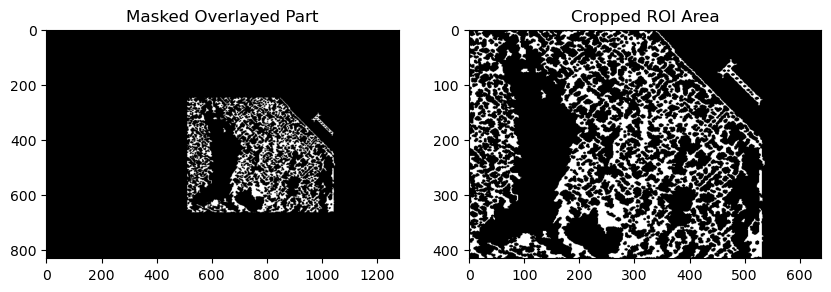

Cropped part saved: /Users/vrishfish/DS Project/Processed_Images/cropped_WhatsApp Image 2024-11-05 at 10.46.59.jpeg
127
25.0 weak   255.0 strong
25.0
255.0


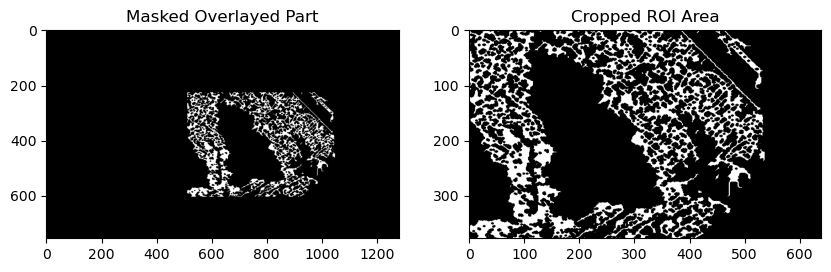

Cropped part saved: /Users/vrishfish/DS Project/Processed_Images/cropped_WhatsApp Image 2024-11-05 at 14.49.12.jpeg


In [12]:
# Define input and output directories
input_dir = "/Users/vrishfish/DS Project/Input Images"
output_dir = "/Users/vrishfish/DS Project/Processed_Images"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for file_name in os.listdir(input_dir):
    # Construct the full path to the image
    file_path = os.path.join(input_dir, file_name)
    
    # Read the image
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Could not read image {file_name}")
        continue  # Skip to the next image
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel_size = 4
    sigma = 1
    kernel = gaussian_kernel(kernel_size, sigma)
    filtered_image = cv2.filter2D(img, -1, kernel)

    G, theta = sobel_filters(filtered_image)

    suppressed_image = non_max_suppression(G.astype(np.uint8), theta)

    thresholded_image, weak_threshold, strong_threshold = double_threshold(suppressed_image)
    print(weak_threshold, 'weak  ', strong_threshold, 'strong')
    thresholded_image = thresholded_image.astype(np.float32)

    final_image = hysterisis(thresholded_image, weak_threshold, strong_threshold)
    final_image = final_image.astype(np.float32)

    edge_image = final_image
    edgelist = get_edgelist(edge_image)

    # Close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    edges = cv2.morphologyEx(final_image, cv2.MORPH_CLOSE, kernel)

    # # Define ROI for the left ventricle (modify coordinates based on your image)
    # roi = np.zeros_like(final_image, dtype=np.uint8)
    # kernel = np.ones((5, 5), np.uint8)
    # roi = cv2.dilate(roi, kernel, iterations=2)  # Expand ROI by 2 iterations

    # cv2.rectangle(roi, (30, 30), (350, 350), 255, -1)  # Expand the ROI # Example ROI (adjust as needed)

    # Define dynamic ROI based on image dimensions
    height, width = edges.shape[:2]

    # Adjust ROI for center or right region
    x1 = int(width * 0.4)  # Start from 40% of the width
    y1 = int(height * 0.3)  # Start from 30% of the height
    x2 = int(width * 0.9)  # End at 90% of the width
    y2 = int(height * 0.8)  # End at 80% of the height

    # Create the ROI mask
    roi = np.zeros_like(edges, dtype=np.uint8)
    cv2.rectangle(roi, (x1, y1), (x2, y2), 255, -1)

    # Visualize the ROI overlay on the edge image
    # plt.imshow(edges, cmap='gray')
    # plt.imshow(roi, cmap='jet', alpha=0.3)  # Overlay ROI
    # plt.title("Dynamic ROI Overlay")
    # plt.show()


    # Filter edges by ROI
    filtered_edgelist = filter_edgelist_by_roi(edgelist, roi)

    # Cluster and extract the largest edge component
    largest_component = cluster_and_extract_largest_component(filtered_edgelist, img.shape[:2])

    # # Save and display the segmented left ventricle

    # cv2.imwrite("segmented_output.jpg", largest_component)
    # plt.imshow(largest_component, cmap='gray')
    # plt.title("Left Ventricle Segmentation")
    # plt.show()

    if roi.shape != edges.shape:
        roi = cv2.resize(roi, (edges.shape[1], edges.shape[0]))

    if roi.dtype != edges.dtype:
        roi = roi.astype(edges.dtype)

    # Mask the edge image
    overlayed_part = cv2.bitwise_and(edges, roi)
    # Crop the ROI area
    cropped_part = overlayed_part[y1:y2, x1:x2]

    # Visualize the results
    plt.figure(figsize=(10, 5))

    # Show the masked part
    plt.subplot(1, 2, 1)
    plt.imshow(overlayed_part, cmap='gray')
    plt.title("Masked Overlayed Part")

    # Show the cropped part
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_part, cmap='gray')
    plt.title("Cropped ROI Area")

    plt.show()

    # Save the cropped part in the output directory
    output_file_path = os.path.join(output_dir, f"cropped_{file_name}")
    cv2.imwrite(output_file_path, cropped_part)
    print(f"Cropped part saved: {output_file_path}")